# Quantize a Segmentation Model and Show Live Inference

## Kidney Segmentation with PyTorch Lightning and OpenVINO™ - Part 3

This tutorial is a part of a series on how to train, optimize, quantize and show live inference on a medical segmentation model. The goal is to accelerate inference on a kidney segmentation model. The [UNet](https://arxiv.org/abs/1505.04597) model is trained from scratch; the data is from [Kits19](https://github.com/neheller/kits19).

This third tutorial in the series shows how to:

- Convert an Original model to OpenVINO IR with [model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html)
- Quantize a PyTorch model with NNCF
- Evaluate the F1 score metric of the original model and the quantized model
- Benchmark performance of the FP32 model and the INT8 quantized model
- Show live inference with OpenVINO's async API

All notebooks in this series:

- [Data Preparation for 2D Segmentation of 3D Medical Data](data-preparation-ct-scan.ipynb)
- [Train a 2D-UNet Medical Imaging Model with PyTorch Lightning](pytorch-monai-training.ipynb)
- Convert and Quantize a Segmentation Model and Show Live Inference (this notebook)
- [Live Inference and Benchmark CT-scan data](ct-scan-live-inference.ipynb) 

## Instructions

This notebook needs a trained UNet model. We provide a pre-trained model, trained for 20 epochs with the full [Kits-19](https://github.com/neheller/kits19) frames dataset, which has an F1 score on the validation set of 0.9. The training code is available in [this notebook](pytorch-monai-training.ipynb). 

NNCF for PyTorch models requires a C++ compiler. On Windows, install [Microsoft Visual Studio 2019](https://docs.microsoft.com/en-us/visualstudio/releases/2019/release-notes). During installation, choose Desktop development with C++ in the Workloads tab. On macOS, 
run `xcode-select –install` from a Terminal. On Linux, install `gcc`.

Running this notebook with the full dataset will take a long time. For demonstration purposes, this tutorial will download one converted CT scan and use that scan for quantization and inference. For production purposes, use a representative dataset for quantizing the model.


#### Table of contents:

- [Imports](#Imports)
- [Settings](#Settings)
- [Load PyTorch Model](#Load-PyTorch-Model)
- [Download CT-scan Data](#Download-CT-scan-Data)
- [Configuration](#Configuration)
    - [Dataset](#Dataset)
    - [Metric](#Metric)
- [Quantization](#Quantization)
- [Compare FP32 and INT8 Model](#Compare-FP32-and-INT8-Model)
    - [Compare File Size](#Compare-File-Size)
    - [Compare Metrics for the original model and the quantized model to be sure that there no degradation.](#Compare-Metrics-for-the-original-model-and-the-quantized-model-to-be-sure-that-there-no-degradation.)
    - [Compare Performance of the FP32 IR Model and Quantized Models](#Compare-Performance-of-the-FP32-IR-Model-and-Quantized-Models)
    - [Visually Compare Inference Results](#Visually-Compare-Inference-Results)
- [Show Live Inference](#Show-Live-Inference)
    - [Load Model and List of Image Files](#Load-Model-and-List-of-Image-Files)
    - [Show Inference](#Show-Inference)
- [References](#References)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/ct-segmentation-quantize/ct-segmentation-quantize-nncf.ipynb" />


In [ ]:
%pip install -q "openvino>=2023.3.0" "monai>=0.9.1" "torchmetrics>=0.11.0" "nncf>=2.8.0" "opencv-python" "matplotlib>=3.4" torch tqdm --extra-index-url https://download.pytorch.org/whl/cpu

## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
import logging
import os
import time
import warnings
import zipfile
from pathlib import Path
from typing import Union

warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
import nncf
import openvino as ov
from monai.transforms import LoadImage
from nncf.common.logging.logger import set_log_level
from torchmetrics import F1Score as F1
import requests


set_log_level(logging.ERROR)  # Disables all NNCF info and warning messages

# Fetch `notebook_utils` module
r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file, device_widget

if not Path("./custom_segmentation.py").exists():
    download_file(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/ct-segmentation-quantize/custom_segmentation.py")
from custom_segmentation import SegmentationModel

if not Path("./async_pipeline.py").exists():
    download_file(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/ct-segmentation-quantize/async_pipeline.py")
from async_pipeline import show_live_inference

2024-09-02 09:47:42.404636: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 09:47:42.406481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 09:47:42.442691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 09:47:43.137453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


## Settings
[back to top ⬆️](#Table-of-contents:)

By default, this notebook will download one CT scan from the KITS19 dataset that will be used for quantization.

In [3]:
BASEDIR = Path("kits19_frames_1")
# Uncomment the line below to use the full dataset, as prepared in the data preparation notebook
# BASEDIR = Path("~/kits19/kits19_frames").expanduser()
MODEL_DIR = Path("model")
MODEL_DIR.mkdir(exist_ok=True)

## Load PyTorch Model
[back to top ⬆️](#Table-of-contents:)

Download the pre-trained model weights, load the PyTorch model and the `state_dict` that was saved after training. The model used in this notebook is a [BasicUNet](https://docs.monai.io/en/stable/networks.html#basicunet) model from [MONAI](https://monai.io). We provide a pre-trained checkpoint. To see how this model performs, check out the [training notebook](pytorch-monai-training.ipynb).

In [4]:
state_dict_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/kidney-segmentation-kits19/unet_kits19_state_dict.pth"
state_dict_file = download_file(state_dict_url, directory="pretrained_model")
state_dict = torch.load(state_dict_file, map_location=torch.device("cpu"))

new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("_model.", "")
    new_state_dict[new_key] = v
new_state_dict.pop("loss_function.pos_weight")

model = monai.networks.nets.BasicUNet(spatial_dims=2, in_channels=1, out_channels=1).eval()
model.load_state_dict(new_state_dict)

pretrained_model/unet_kits19_state_dict.pth:   0%|          | 0.00/7.58M [00:00<?, ?B/s]

BasicUNet features: (32, 32, 64, 128, 256, 32).


/tmp/ipykernel_3326568/1592321960.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_file, map_location=torch.device("cpu"))


<All keys matched successfully>

## Download CT-scan Data
[back to top ⬆️](#Table-of-contents:)


In [5]:
# The CT scan case number. For example: 2 for data from the case_00002 directory
# Currently only 117 is supported
CASE = 117
if not (BASEDIR / f"case_{CASE:05d}").exists():
    BASEDIR.mkdir(exist_ok=True)
    filename = download_file(f"https://storage.openvinotoolkit.org/data/test_data/openvino_notebooks/kits19/case_{CASE:05d}.zip")
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall(path=BASEDIR)
    os.remove(filename)  # remove zipfile
    print(f"Downloaded and extracted data for case_{CASE:05d}")
else:
    print(f"Data for case_{CASE:05d} exists")

Data for case_00117 exists


## Configuration
[back to top ⬆️](#Table-of-contents:)


### Dataset
[back to top ⬆️](#Table-of-contents:)

The `KitsDataset` class in the next cell expects images and masks in the *`basedir`* directory, in a folder per patient. It is a simplified version of the Dataset class in the [training notebook](pytorch-monai-training.ipynb).

Images are loaded with MONAI's [`LoadImage`](https://docs.monai.io/en/stable/transforms.html#loadimage), to align with the image loading method in the training notebook. This method rotates and flips the images. We define a `rotate_and_flip` method to display the images in the expected orientation:

In [6]:
def rotate_and_flip(image):
    """Rotate `image` by 90 degrees and flip horizontally"""
    return cv2.flip(cv2.rotate(image, rotateCode=cv2.ROTATE_90_CLOCKWISE), flipCode=1)


class KitsDataset:
    def __init__(self, basedir: str):
        """
        Dataset class for prepared Kits19 data, for binary segmentation (background/kidney)
        Source data should exist in basedir, in subdirectories case_00000 until case_00210,
        with each subdirectory containing directories imaging_frames, with jpg images, and
        segmentation_frames with segmentation masks as png files.
        See [data-preparation-ct-scan](./data-preparation-ct-scan.ipynb)

        :param basedir: Directory that contains the prepared CT scans
        """
        masks = sorted(BASEDIR.glob("case_*/segmentation_frames/*png"))

        self.basedir = basedir
        self.dataset = masks
        print(f"Created dataset with {len(self.dataset)} items. " f"Base directory for data: {basedir}")

    def __getitem__(self, index):
        """
        Get an item from the dataset at the specified index.

        :return: (image, segmentation_mask)
        """
        mask_path = self.dataset[index]
        image_path = str(mask_path.with_suffix(".jpg")).replace("segmentation_frames", "imaging_frames")

        # Load images with MONAI's LoadImage to match data loading in training notebook
        mask = LoadImage(image_only=True, dtype=np.uint8)(str(mask_path)).numpy()
        img = LoadImage(image_only=True, dtype=np.float32)(str(image_path)).numpy()

        if img.shape[:2] != (512, 512):
            img = cv2.resize(img.astype(np.uint8), (512, 512)).astype(np.float32)
            mask = cv2.resize(mask, (512, 512))

        input_image = np.expand_dims(img, axis=0)
        return input_image, mask

    def __len__(self):
        return len(self.dataset)

To test whether the data loader returns the expected output, we show an image and a mask. The image and the mask are returned by the dataloader, after resizing and preprocessing. Since this dataset contains a lot of slices without kidneys, we select a slice that contains at least 5000 kidney pixels to verify that the annotations look correct:

Created dataset with 69 items. Base directory for data: kits19_frames_1


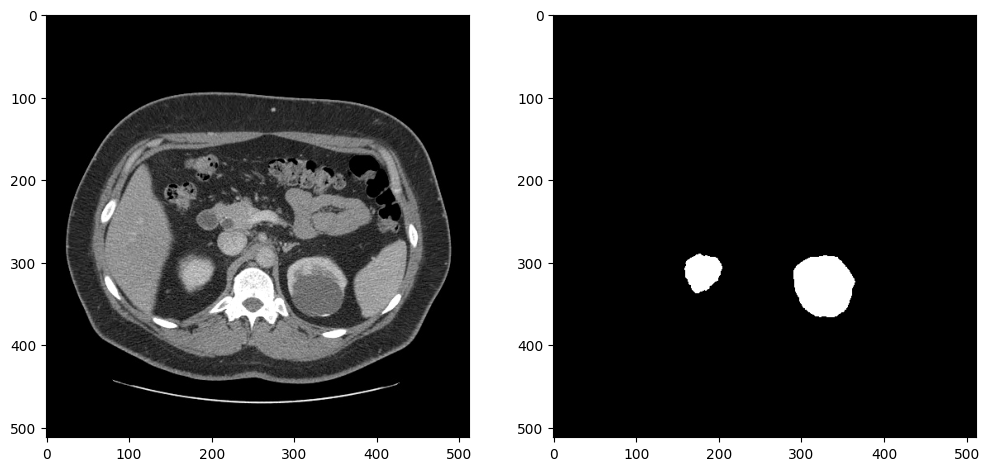

In [7]:
dataset = KitsDataset(BASEDIR)
# Find a slice that contains kidney annotations
# item[0] is the annotation: (id, annotation_data)
image_data, mask = next(item for item in dataset if np.count_nonzero(item[1]) > 5000)
# Remove extra image dimension and rotate and flip the image for visualization
image = rotate_and_flip(image_data.squeeze())

# The data loader returns annotations as (index, mask) and mask in shape (H,W)
mask = rotate_and_flip(mask)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap="gray")
ax[1].imshow(mask, cmap="gray");

### Metric
[back to top ⬆️](#Table-of-contents:)

Define a metric to determine the performance of the model.

For this demo, we use the [F1 score](https://en.wikipedia.org/wiki/F-score), or Dice coefficient, from the [TorchMetrics](https://torchmetrics.readthedocs.io/en/stable/) library.

In [8]:
def compute_f1(model: Union[torch.nn.Module, ov.CompiledModel], dataset: KitsDataset):
    """
    Compute binary F1 score of `model` on `dataset`
    F1 score metric is provided by the torchmetrics library
    `model` is expected to be a binary segmentation model, images in the
    dataset are expected in (N,C,H,W) format where N==C==1
    """
    metric = F1(ignore_index=0, task="binary", average="macro")
    with torch.no_grad():
        for image, target in dataset:
            input_image = torch.as_tensor(image).unsqueeze(0)
            if isinstance(model, ov.CompiledModel):
                output_layer = model.output(0)
                output = model(input_image)[output_layer]
                output = torch.from_numpy(output)
            else:
                output = model(input_image)
            label = torch.as_tensor(target.squeeze()).long()
            prediction = torch.sigmoid(output.squeeze()).round().long()
            metric.update(label.flatten(), prediction.flatten())
    return metric.compute()

## Quantization
[back to top ⬆️](#Table-of-contents:)

Before quantizing the model, we compute the F1 score on the `FP32` model, for comparison:

In [9]:
fp32_f1 = compute_f1(model, dataset)
print(f"FP32 F1: {fp32_f1:.3f}")

FP32 F1: 0.999


We convert the PyTorch model to OpenVINO IR and serialize it for comparing the performance of the `FP32` and `INT8` model later in this notebook.

In [10]:
fp32_ir_path = MODEL_DIR / Path("unet_kits19_fp32.xml")
dummy_input = torch.randn(1, 1, 512, 512)

fp32_ir_model = ov.convert_model(model, example_input=dummy_input, input=dummy_input.shape)
ov.save_model(fp32_ir_model, str(fp32_ir_path))

[ WARNING ]  Please fix your imports. Module %s has been moved to %s. The old module will be deleted in version %s.
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/monai/networks/nets/basic_unet.py:179: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x_e.shape[-i - 1] != x_0.shape[-i - 1]:


[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.

> **Note**: NNCF Post-training Quantization is available in OpenVINO 2023.0 release.

Create a quantized model from the pre-trained `FP32` model and the calibration dataset. The optimization process contains the following steps:

    1. Create a Dataset for quantization.
    2. Run `nncf.quantize` for getting an optimized model.
    3. Export the quantized model to OpenVINO IR model.
    4. Serialize the INT8 model using `ov.save_model` function for benchmarking.

In [11]:
def transform_fn(data_item):
    """
    Extract the model's input from the data item.
    The data item here is the data item that is returned from the data source per iteration.
    This function should be passed when the data item cannot be used as model's input.
    """
    images, _ = data_item
    return images


data_loader = torch.utils.data.DataLoader(dataset)
calibration_dataset = nncf.Dataset(data_loader, transform_fn)
quantized_model = nncf.quantize(
    model,
    calibration_dataset,
    # Do not quantize LeakyReLU activations to allow the INT8 model to run on Intel GPU
    ignored_scope=nncf.IgnoredScope(patterns=[".*LeakyReLU.*"]),
)

Output()

Output()

Convert quantized model to OpenVINO IR model and save it.

In [12]:
dummy_input = torch.randn(1, 1, 512, 512)
int8_ir_path = MODEL_DIR / "unet_kits19_int8.xml"
int8_ir_model = ov.convert_model(quantized_model, example_input=dummy_input, input=dummy_input.shape)
ov.save_model(int8_ir_model, str(int8_ir_path))

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/nncf/torch/quantization/layers.py:340: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self._level_low.item()
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/nncf/torch/quantization/layers.py:348: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self._level_high.item()
/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/monai/networks/nets/basic_unet.py:179: TracerWarning: Converting a tensor to a Python boolean might cause the trace 

This notebook demonstrates post-training quantization with NNCF.

NNCF also supports quantization-aware training, and other algorithms than quantization. See the [NNCF documentation](https://github.com/openvinotoolkit/nncf/) in the NNCF repository for more information.

## Compare FP32 and INT8 Model
[back to top ⬆️](#Table-of-contents:)

### Compare File Size
[back to top ⬆️](#Table-of-contents:)


In [13]:
fp32_ir_model_size = fp32_ir_path.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = int8_ir_path.with_suffix(".bin").stat().st_size / 1024

print(f"FP32 IR model size: {fp32_ir_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")

FP32 IR model size: 3864.14 KB
INT8 model size: 1953.48 KB


### Select Inference Device
[back to top ⬆️](#Table-of-contents:)

In [14]:
core = ov.Core()
# By default, benchmark on MULTI:CPU,GPU if a GPU is available, otherwise on CPU.
device_list = ["MULTI:CPU,GPU" if "GPU" in core.available_devices else "AUTO"]

device = device_widget(device_list[0], added=device_list)
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Compare Metrics for the original model and the quantized model to be sure that there no degradation.
[back to top ⬆️](#Table-of-contents:)


In [15]:
int8_compiled_model = core.compile_model(int8_ir_model, device.value)
int8_f1 = compute_f1(int8_compiled_model, dataset)

print(f"FP32 F1: {fp32_f1:.3f}")
print(f"INT8 F1: {int8_f1:.3f}")

FP32 F1: 0.999
INT8 F1: 0.999


### Compare Performance of the FP32 IR Model and Quantized Models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP32` and `INT8` models, we use [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) - OpenVINO's inference performance measurement tool. Benchmark tool is a command line application, part of OpenVINO development tools, that can be run in the notebook with `! benchmark_app` or `%sx benchmark_app`.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see all command line options.

In [16]:
# ! benchmark_app --help

In [17]:
# Benchmark FP32 model
! benchmark_app -m $fp32_ir_path -d $device.value -t 15 -api sync

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.3.0-16041-1e3b88e4e3f-releases/2024/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.3.0-16041-1e3b88e4e3f-releases/2024/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.LATENCY.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 10.43 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,1,512,512]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.final_conv/aten::_convolution/Add) : f32 / [...] / [1,1,512,512]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model

In [18]:
# Benchmark INT8 model
! benchmark_app -m $int8_ir_path -d $device.value -t 15 -api sync

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.3.0-16041-1e3b88e4e3f-releases/2024/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.3.0-16041-1e3b88e4e3f-releases/2024/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.LATENCY.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 12.35 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,1,512,512]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.final_conv/aten::_convolution/Add) : f32 / [...] / [1,1,512,512]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model

### Visually Compare Inference Results
[back to top ⬆️](#Table-of-contents:)

Visualize the results of the model on four slices of the validation set. Compare the results of the `FP32` IR model with the results of the quantized `INT8` model and the reference segmentation annotation.

Medical imaging datasets tend to be very imbalanced: most of the slices in a CT scan do not contain kidney data. The segmentation model should be good at finding kidneys where they exist (in medical terms: have good sensitivity) but also not find spurious kidneys that do not exist (have good specificity). In the next cell, there are four slices: two slices that have no kidney data, and two slices that contain kidney data. For this example, a slice has kidney data if at least 50 pixels in the slices are annotated as kidney.

Run this cell again to show results on a different subset. The random seed is displayed to enable reproducing specific runs of this cell.

> **NOTE**: the images are shown after optional augmenting and resizing. In the Kits19 dataset all but one of the cases has the `(512, 512)` input shape.

Visualizing results with seed 1725256144


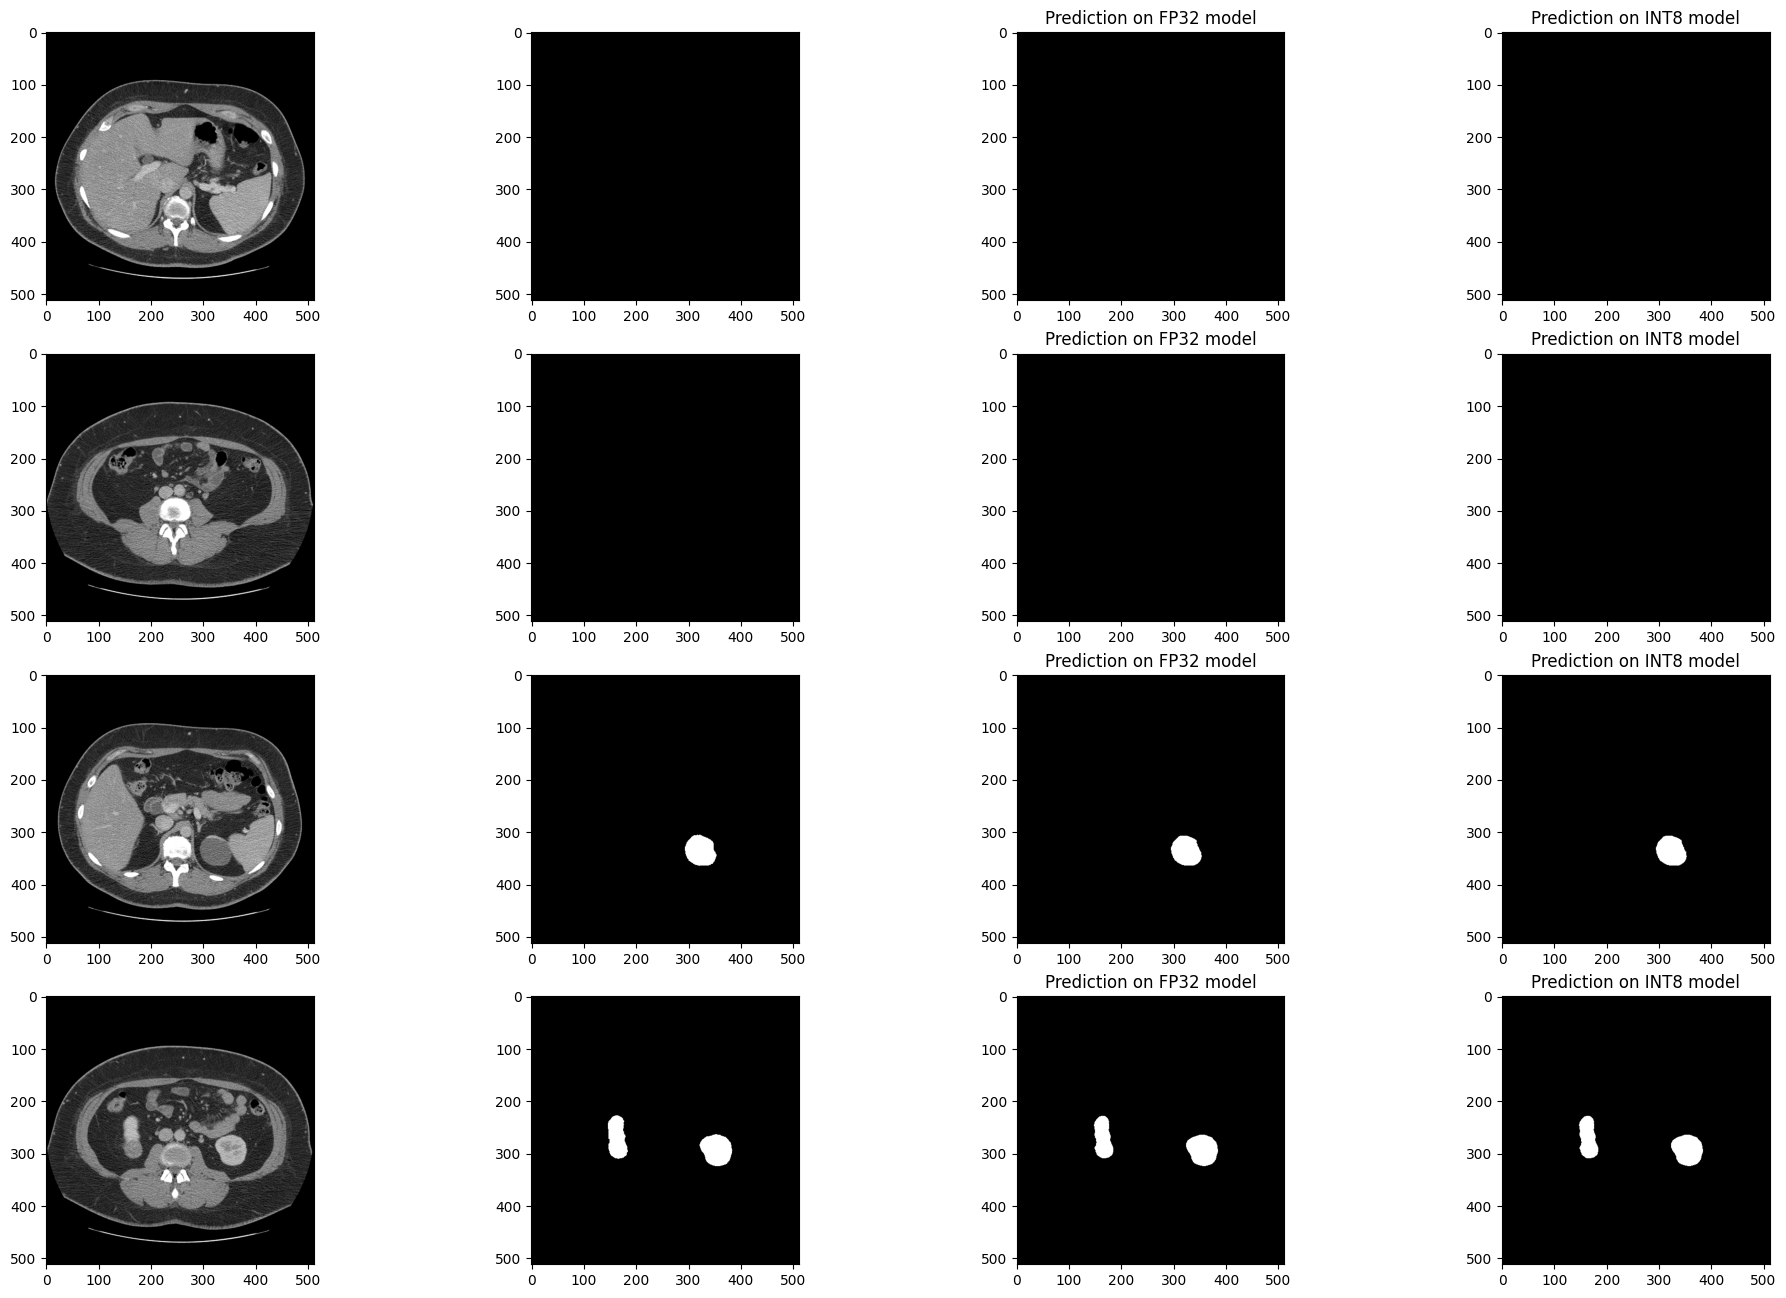

In [19]:
# The sigmoid function is used to transform the result of the network
# to binary segmentation masks
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))


num_images = 4
colormap = "gray"

# Load FP32 and INT8 models
core = ov.Core()
fp_model = core.read_model(fp32_ir_path)
int8_model = core.read_model(int8_ir_path)
compiled_model_fp = core.compile_model(fp_model, device_name=device.value)
compiled_model_int8 = core.compile_model(int8_model, device_name=device.value)
output_layer_fp = compiled_model_fp.output(0)
output_layer_int8 = compiled_model_int8.output(0)

# Create subset of dataset
background_slices = (item for item in dataset if np.count_nonzero(item[1]) == 0)
kidney_slices = (item for item in dataset if np.count_nonzero(item[1]) > 50)

background_slices_l = list(background_slices)
kidney_slices_l = list(kidney_slices)
if len(background_slices_l) != 0:
    background_id = np.random.choice(len(background_slices_l), 2)
    kidney_id = np.random.choice(len(kidney_slices_l), 2)
    data_subset = [background_slices_l[idx] for idx in background_id] + [kidney_slices_l[idx] for idx in kidney_id]
else:
    kidkey_id = np.random.choice(len(kidneyslices_l), 2)
    data_subset = [kidney_slices_l[idx] for idx in kidney_id]

# Set seed to current time. To reproduce specific results, copy the printed seed
# and manually set `seed` to that value.
seed = int(time.time())
np.random.seed(seed)
print(f"Visualizing results with seed {seed}")

fig, ax = plt.subplots(nrows=num_images, ncols=4, figsize=(24, num_images * 4))
for i, (image, mask) in enumerate(data_subset):
    display_image = rotate_and_flip(image.squeeze())
    target_mask = rotate_and_flip(mask).astype(np.uint8)
    # Add batch dimension to image and do inference on FP and INT8 models
    input_image = np.expand_dims(image, 0)
    res_fp = compiled_model_fp([input_image])
    res_int8 = compiled_model_int8([input_image])

    # Process inference outputs and convert to binary segementation masks
    result_mask_fp = sigmoid(res_fp[output_layer_fp]).squeeze().round().astype(np.uint8)
    result_mask_int8 = sigmoid(res_int8[output_layer_int8]).squeeze().round().astype(np.uint8)
    result_mask_fp = rotate_and_flip(result_mask_fp)
    result_mask_int8 = rotate_and_flip(result_mask_int8)

    # Display images, annotations, FP32 result and INT8 result
    ax[i, 0].imshow(display_image, cmap=colormap)
    ax[i, 1].imshow(target_mask, cmap=colormap)
    ax[i, 2].imshow(result_mask_fp, cmap=colormap)
    ax[i, 3].imshow(result_mask_int8, cmap=colormap)
    ax[i, 2].set_title("Prediction on FP32 model")
    ax[i, 3].set_title("Prediction on INT8 model")

## Show Live Inference
[back to top ⬆️](#Table-of-contents:)

To show live inference on the model in the notebook, we will use the asynchronous processing feature of OpenVINO.

We use the `show_live_inference` function from [Notebook Utils](../../utils/notebook_utils.ipynb) to show live inference. This function uses [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)'s Async Pipeline and Model API to perform asynchronous inference. After inference on the specified CT scan has completed, the total time and throughput (fps), including preprocessing and displaying, will be printed.

> **NOTE**: If you experience flickering on Firefox, consider using Chrome or Edge to run this notebook.

### Load Model and List of Image Files
[back to top ⬆️](#Table-of-contents:)

We load the segmentation model to OpenVINO Runtime with `SegmentationModel`, based on the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) Model API. This model implementation includes pre and post processing for the model. For `SegmentationModel`, this includes the code to create an overlay of the segmentation mask on the original image/frame.

In [20]:
CASE = 117

segmentation_model = SegmentationModel(ie=core, model_path=int8_ir_path, sigmoid=True, rotate_and_flip=True)
case_path = BASEDIR / f"case_{CASE:05d}"
image_paths = sorted(case_path.glob("imaging_frames/*jpg"))
print(f"{case_path.name}, {len(image_paths)} images")

case_00117, 69 images


### Show Inference
[back to top ⬆️](#Table-of-contents:)

In the next cell, we run the `show_live_inference` function, which loads the `segmentation_model` to the specified `device` (using caching for faster model loading on GPU devices), loads the images, performs inference, and displays the results on the frames loaded in `images` in real-time.

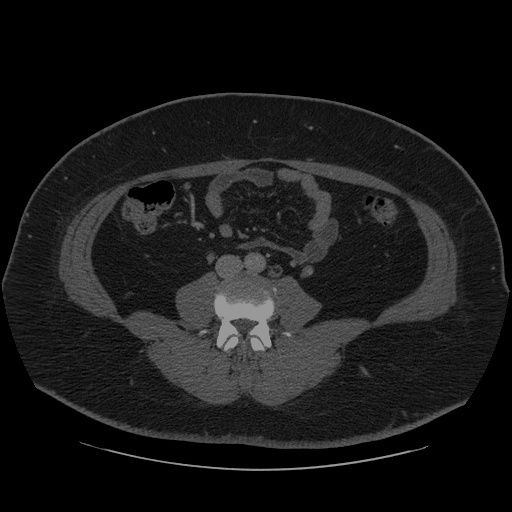

Loaded model to AUTO in 0.15 seconds.
Total time for 68 frames: 2.74 seconds, fps:25.18


In [21]:
reader = LoadImage(image_only=True, dtype=np.uint8)
show_live_inference(
    ie=core,
    image_paths=image_paths,
    model=segmentation_model,
    device=device.value,
    reader=reader,
)

## References
[back to top ⬆️](#Table-of-contents:)

**OpenVINO**
- [NNCF Repository](https://github.com/openvinotoolkit/nncf/)
- [Neural Network Compression Framework for fast model inference](https://arxiv.org/abs/2002.08679)
- [OpenVINO API Tutorial](../openvino-api/openvino-api.ipynb)
- [OpenVINO PyPI (pip install openvino)](https://pypi.org/project/openvino/)

**Kits19 Data**
  - [Kits19 Challenge Homepage](https://kits19.grand-challenge.org/)
  - [Kits19 GitHub Repository](https://github.com/neheller/kits19)
  - [The KiTS19 Challenge Data: 300 Kidney Tumor Cases with Clinical Context, CT Semantic Segmentations, and Surgical Outcomes](https://arxiv.org/abs/1904.00445)
  - [The state of the art in kidney and kidney tumor segmentation in contrast-enhanced CT imaging: Results of the KiTS19 challenge](https://www.sciencedirect.com/science/article/pii/S1361841520301857)
